# SAN - Praktische Arbeit (Marvel Universe Social Network)

## Netzwerkanalyse

In [26]:
import os
import sys
import random
import itertools
import pandas as pd
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite, centrality, community
import matplotlib.pyplot as plt

from helper import *

### Daten einlesen

In [27]:
nodes_df = pd.read_csv('Daten/nodes.csv')
edges_df = pd.read_csv('Daten/edges.csv')
df_heros = pd.read_csv('Daten/hero-network.csv')

# use filtered?
edges_filtered = pd.read_csv('Daten/filtered_edges.csv')

### Initiales Netzwerk

Hier erstellen wir ein ungerichtetes, bipartites Netzwerk mit allen Verbindungen, ohne Filterungen.

In [28]:
B = nx.Graph()

heroes = nodes_df[nodes_df['type'] == 'hero']['node']
comics = nodes_df[nodes_df['type'] == 'comic']['node']

B.add_nodes_from(heroes, bipartite=0)  # label heroes as 0
B.add_nodes_from(comics, bipartite=1)  # label comics as 1
B.name = "Marvel Universe"

# Add edges based on the edges_df data
# Each row in edges_df is an edge between a hero and a comic
for _, row in edges_df.iterrows():
    B.add_edge(row['hero'], row['comic'])

print_network_information(B)

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 19091
	Number of edges: 96104


Eine Gruppe von Knoten repräsentiert Helden, die andere Gruppe repräsentiert Comics. Eine Kante wird zwischen einem Helden und einem Comic hinzugefügt, wenn der Held in diesem Comic vorkommt.

Da der Datensatz sehr gross ist, werden wir nun ein Sample des Netzwerks erstellen, um die Struktur des Netzwerks übersichtlich zu visualisieren. Hierzu wenden wir Random Walk Sampling an: Wir beginnen bei einem zufälligen Knoten (entweder ein Held oder ein Comic) und führen einen Random Walk durch, um verbundene Knoten zu sammeln. Dadurch können wir sicherstellen, dass die ausgewählten Helden und Comics tatsächlich miteinander verbunden sind.

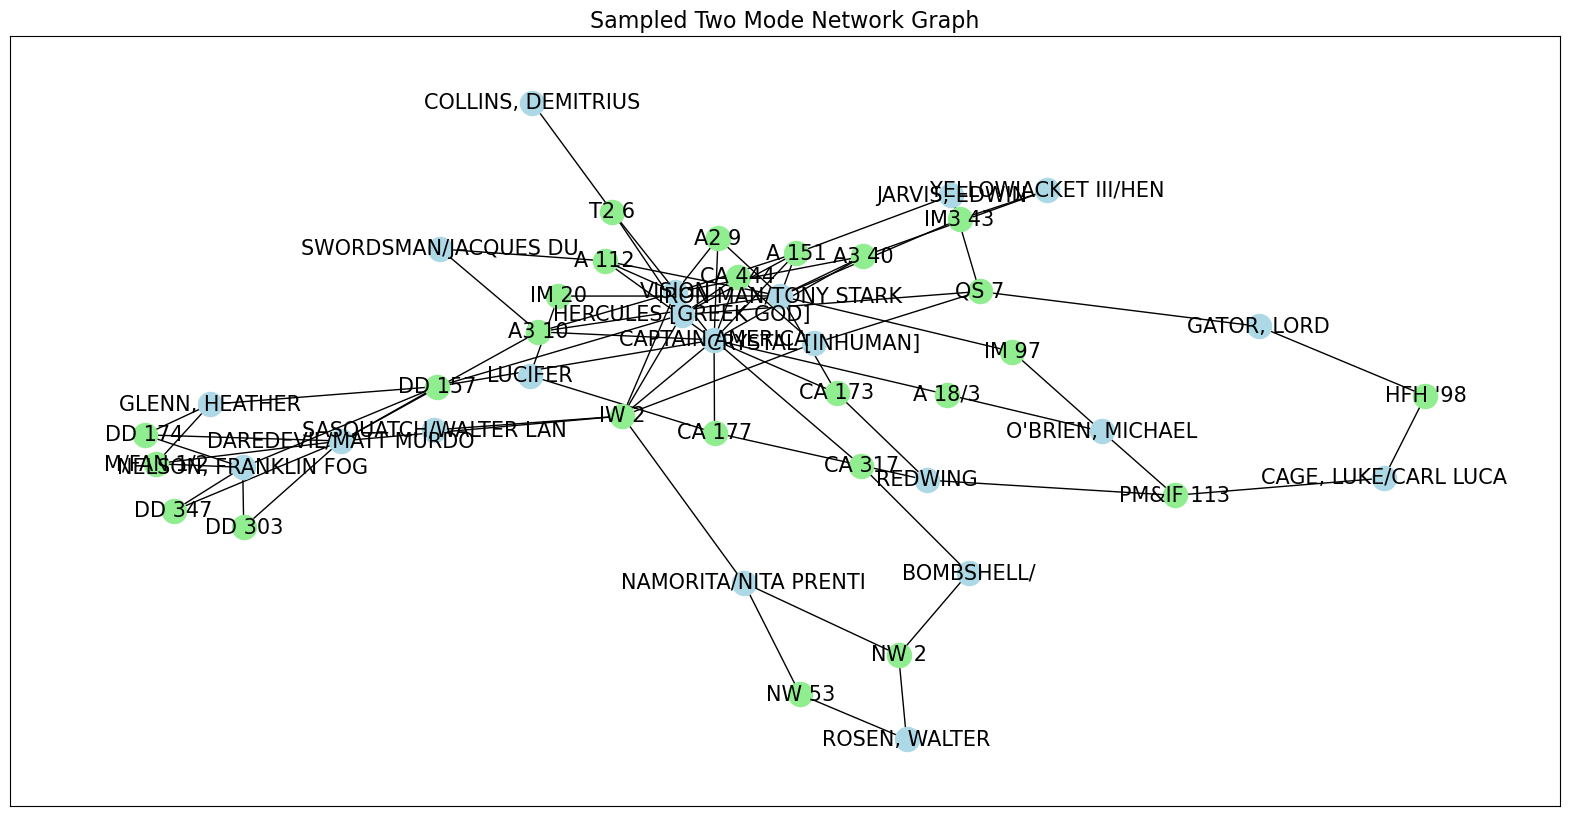

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 46
	Number of edges: 80


In [29]:
# Randomly select a starting node (either hero or comic)
starting_node = random.choice(list(B.nodes()))

# Perform a random walk to get a sample of the network
sampled_nodes = perform_random_walk(B, starting_node, num_steps=50)

# Create a subgraph with the sampled nodes
sampled_graph = B.subgraph(sampled_nodes)

sampled_heroes_nodes = [node for node in heroes if node in sampled_graph.nodes]
sampled_comics_nodes = [node for node in comics if node in sampled_graph.nodes]

# Draw the sampled graph
plt.figure(figsize=(20, 10))
plt.title("Sampled Two Mode Network Graph", fontsize=16)
draw_graph_and_color_groups(sampled_graph, groups=[sampled_heroes_nodes, sampled_comics_nodes], layout="spring")
plt.show()

print_network_information(sampled_graph)

Das Diagramm zeigt die Stichprobe des Marvel Universe Netzwerks, das aus einem Random Walk mit 50 Schritten resultiert, wobei blaue Knoten Helden repräsentieren, grüne Knoten Comics repräsentieren und die Linien die Verbindungen zwischen ihnen darstellen.

In diesem Netzwerk gibt es keine direkten Verbindungen zwischen Helden oder zwischen Comics untereinander. Stattdessen sind die Helden mit Comics verbunden, was anzeigt, in welchen Comics die jeweiligen Helden erscheinen. Diese Struktur ist typisch für bipartite Netzwerke, in denen die beiden Knotentypen unterschiedliche Entitäten darstellen (in diesem Fall Helden und Comics) und die Kanten die Beziehungen zwischen diesen Entitäten repräsentieren.

### One-Mode-Netzwerk

Da das Netzwerk sehr gross ist, würden die Berechnungen und Darstellungen sehr lange dauern. Deshalb haben wir uns entschieden, das Netzwerk in ein One-Mode-Netzwerk umzuwandeln, in dem die Helden direkt miteinander verbunden sind, wenn sie in mindestens einem Comic gemeinsam auftreten.

In [30]:
# Project the bipartite graph onto heroes nodes using the nodes DataFrame
heroes_nodes = nodes_df[nodes_df['type'] == 'hero']['node'].tolist()

# Project the bipartite graph onto heroes nodes
G_one_mode = bipartite.projected_graph(B, heroes_nodes)

print_network_information(G_one_mode)

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 6440
	Number of edges: 171644


Das One-Mode Netzwerk besteht nun aus 6'440 Knoten, die jeweils einen Helden darstellen. Es gibt 171'644 Kanten im Graphen, wobei jede Kante einen gemeinsamen Comic-Auftritt zwischen zwei Helden anzeigt.

Dazu werden wir auch nur die 100 am häufigsten vorkommenden Helden berücksichtigen, um die Berechnungen zu beschleunigen. 

In [31]:
top_heroes = edges_df['hero'].value_counts().head(100).index.tolist()
top_heroes[:5]

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK']

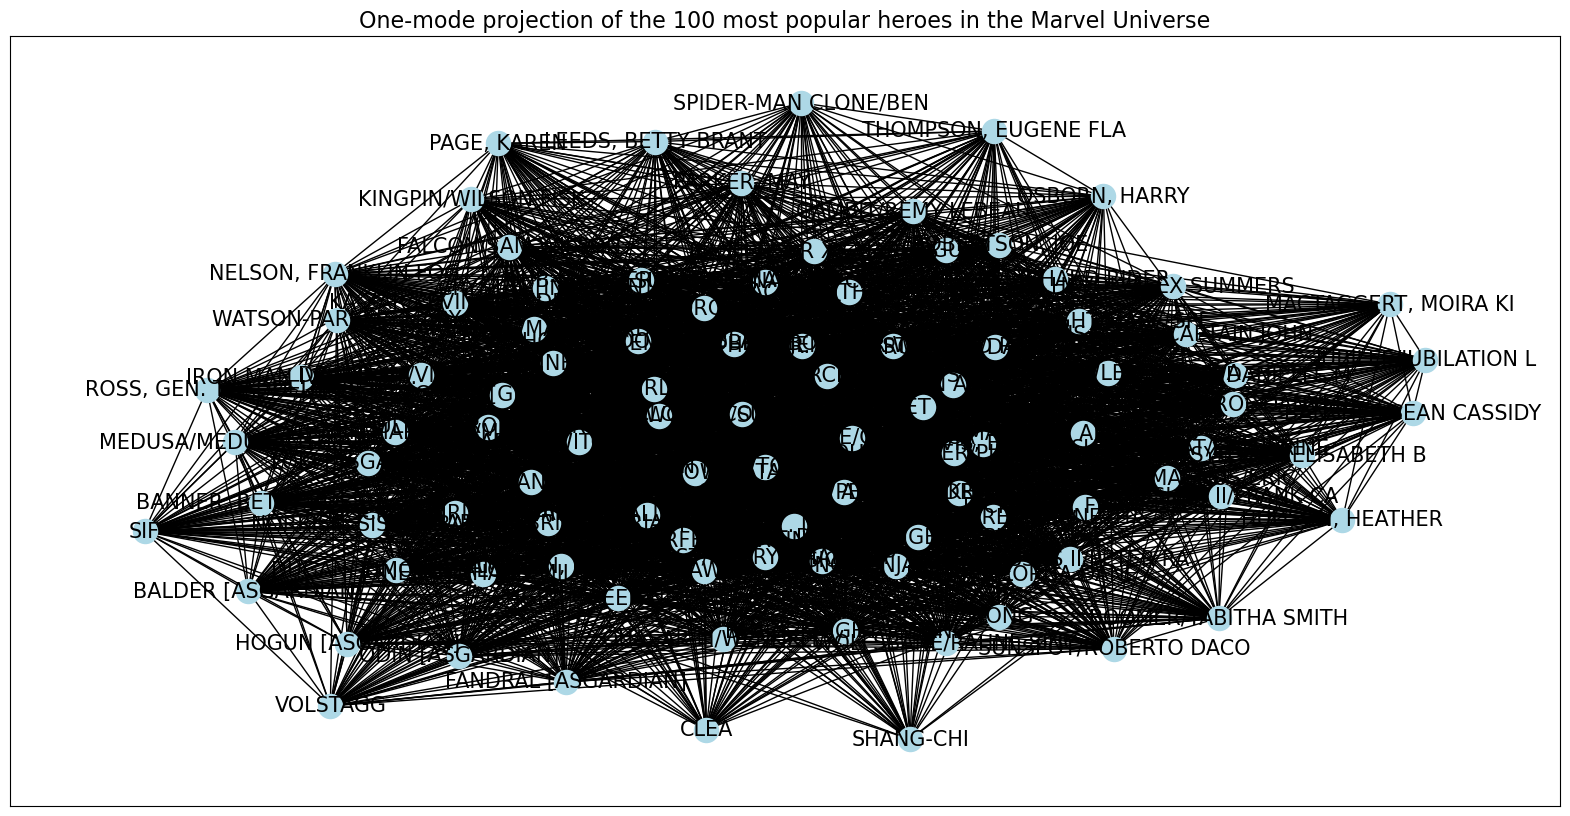

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 100
	Number of edges: 4076


In [32]:
# Filter the one-mode network to only include the top 100 heroes
top_heroes_subgraph = G_one_mode.subgraph(top_heroes)

# Draw the projected graph
plt.figure(figsize=(20, 10))
plt.title("One-mode projection of the 100 most popular heroes in the Marvel Universe", fontsize=16)
draw_graph_and_color_groups(top_heroes_subgraph, layout="spring")
plt.show()

print_network_information(top_heroes_subgraph)

Wir sehen, dass die 100 am häufigsten vorkommenden Helden sehr stark vernetzt sind. Es gibt viele sehr zentrale Helden. Sie könnten als Schlüsselfiguren oder Hauptcharaktere im Marvel-Universum betrachtet werden.

Da wir nun unsere verschiedenen Netzwerke erstellt haben, können wir mit der Analyse beginnen. 

## Frage 1 - Welche Helden sind die zentralsten im Netzwerk?

Um die Frage zu beantworten, welche Helden die zentralsten im Netzwerk sind, werden wir die drei genannten Zentralitätsmasse verwenden: Degree-Centrality, Betweenness-Centrality und Closeness-Centrality. Diese Masse geben jeweils unterschiedliche Aspekte der Zentralität eines Knotens im Netzwerk an:

- Degree-Centrality misst die Anzahl der direkten Verbindungen, die ein Knoten hat. Für Helden in unserem Netzwerk bedeutet ein hoher Wert, dass sie in vielen verschiedenen Comics erscheinen.

- Betweenness-Centrality gibt an, wie oft ein Knoten auf den kürzesten Pfaden zwischen anderen Knoten liegt. Ein hoher Wert deutet darauf hin, dass der Held eine wichtige Rolle in der Verbindung verschiedener Teile des Netzwerks spielt.

- Closeness-Centrality misst, wie nahe ein Knoten im Durchschnitt zu allen anderen Knoten im Netzwerk liegt. Ein hoher Wert zeigt an, dass ein Held im Durchschnitt schneller mit anderen Knoten verbunden werden kann.

### Ganzes Netzwerk
Beachte: Die Laufzeit der Betweenness und Closeness Zentralitäten dauern jeweils 3.5 und 1 Minute.

In [33]:
# Degree
degree_centrality = nx.degree_centrality(G_one_mode)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_degree_centrality, "Helden mit der höchsten Degree-Zentralität")

# Betweenness
betweenness_centrality = nx.betweenness_centrality(G_one_mode)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_betweenness_centrality, "Helden mit der höchsten Betweenness-Zentralität")

# Closeness
closeness_centrality = nx.closeness_centrality(G_one_mode)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_closeness_centrality, "Helden mit der höchsten Closeness-Zentralität")

Helden mit der höchsten Degree-Zentralität:
  CAPTAIN AMERICA: 0.2980
  SPIDER-MAN/PETER PARKER: 0.2724
  IRON MAN/TONY STARK: 0.2432
  THING/BENJAMIN J. GR: 0.2249
  MR. FANTASTIC/REED R: 0.2199

Helden mit der höchsten Betweenness-Zentralität:
  SPIDER-MAN/PETER PARKER: 0.0712
  CAPTAIN AMERICA: 0.0553
  IRON MAN/TONY STARK: 0.0373
  WOLVERINE/LOGAN: 0.0348
  HAVOK/ALEX SUMMERS: 0.0348

Helden mit der höchsten Closeness-Zentralität:
  CAPTAIN AMERICA: 0.5827
  SPIDER-MAN/PETER PARKER: 0.5734
  IRON MAN/TONY STARK: 0.5620
  THING/BENJAMIN J. GR: 0.5581
  MR. FANTASTIC/REED R: 0.5563



Helden mit der höchsten Degree-Zentralität, wie Captain America und Spider-Man, sind also diejenigen, die mit den meisten anderen Helden direkt verbunden sind. Sie sind möglicherweise die beliebtesten und aktivsten Charaktere, die in einer grossen Anzahl von Comics mit verschiedenen anderen Helden erscheinen.

Spider-Man hat hier die höchste Betweenness-Zentralität, was darauf hindeutet, dass er eine wichtige "Brückenfigur" im Marvel-Universum ist, die verschiedene Gruppen oder Gemeinschaften von Helden miteinander verbindet. Er könnte in vielen Storylines eine zentrale Rolle spielen, die unterschiedliche Helden zusammenführt.

Captain America und Spider-Man haben auch hier die höchsten Werte, was bedeutet, dass sie im Durchschnitt die kürzesten Pfade zu allen anderen Helden im Netzwerk haben. Dies deutet auf ihre zentrale Stellung in der "sozialen Struktur" des Marvel-Universums hin.

### Top 100 Helden Netzwerk

In [34]:
# Degree
degree_centrality = nx.degree_centrality(top_heroes_subgraph)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_degree_centrality, "Helden mit der höchsten Degree-Zentralität")

# Betweenness
betweenness_centrality = nx.betweenness_centrality(top_heroes_subgraph)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_betweenness_centrality, "Helden mit der höchsten Betweenness-Zentralität")

# Closeness
closeness_centrality = nx.closeness_centrality(top_heroes_subgraph)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)
print_centrality(top_closeness_centrality, "Helden mit der höchsten Closeness-Zentralität")

Helden mit der höchsten Degree-Zentralität:
  CAPTAIN AMERICA: 1.0000
  CYCLOPS/SCOTT SUMMER: 1.0000
  MR. FANTASTIC/REED R: 1.0000
  WOLVERINE/LOGAN: 1.0000
  HUMAN TORCH/JOHNNY S: 1.0000

Helden mit der höchsten Betweenness-Zentralität:
  CAPTAIN AMERICA: 0.0037
  CYCLOPS/SCOTT SUMMER: 0.0037
  MR. FANTASTIC/REED R: 0.0037
  WOLVERINE/LOGAN: 0.0037
  HUMAN TORCH/JOHNNY S: 0.0037

Helden mit der höchsten Closeness-Zentralität:
  CAPTAIN AMERICA: 1.0000
  CYCLOPS/SCOTT SUMMER: 1.0000
  MR. FANTASTIC/REED R: 1.0000
  WOLVERINE/LOGAN: 1.0000
  HUMAN TORCH/JOHNNY S: 1.0000



Jeder dieser Helden hat eine Degree-Zentralität und Closeness-Zentralität von 1, was bedeutet, dass sie alle mit jedem anderen Helden im Netzwerk direkt verbunden sind. Die Betweenness-Zentralität ist für alle fünf Helden identisch und ziemlich niedrig, was wiederum die hohe Dichte des Netzwerks und die geringe Notwendigkeit von "Brücken"-Helden in diesem Netzwerk anzeigt.

## Frage 2 - Wie ist die Verteilung der Anzahl der Comics pro Held?

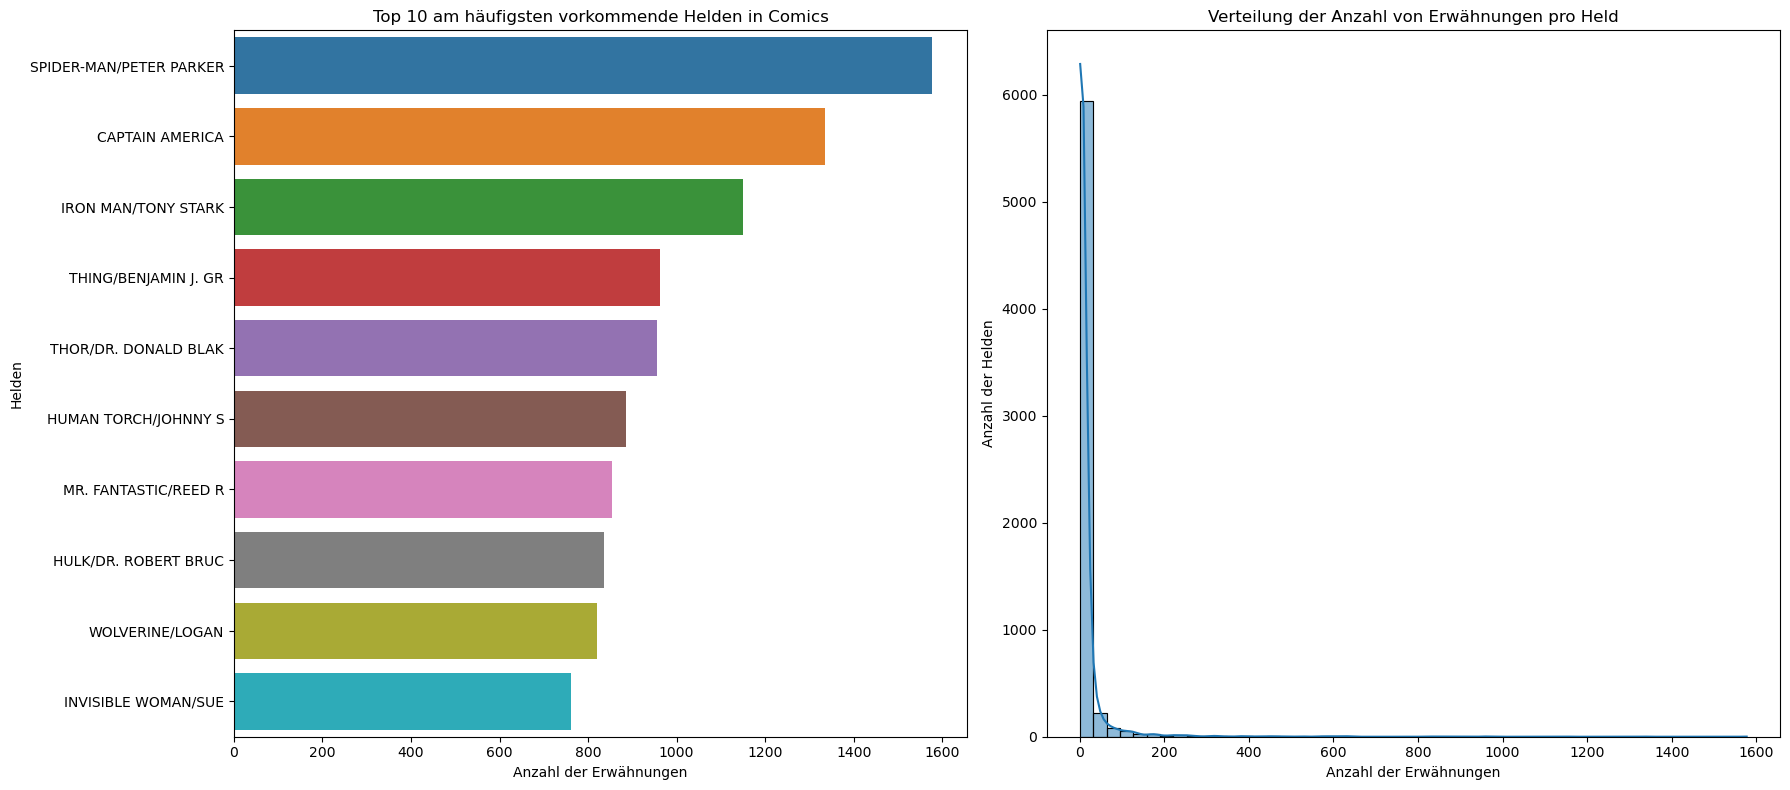

In [35]:
# Count the number of mentions for each hero
hero_mentions = edges_df['hero'].value_counts()
top_heroes = hero_mentions.head(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Top 10 most frequent comics
sns.barplot(x=top_heroes.values, y=top_heroes.index, ax=axes[0])
axes[0].set_title('Top 10 am häufigsten vorkommende Helden in Comics')
axes[0].set_xlabel('Anzahl der Erwähnungen')
axes[0].set_ylabel('Helden')

# Distribution plot of mentions per comic
sns.histplot(hero_mentions, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Verteilung der Anzahl von Erwähnungen pro Held')
axes[1].set_xlabel('Anzahl der Erwähnungen')
axes[1].set_ylabel('Anzahl der Helden')

plt.tight_layout()
plt.show()

## Frage 3 - Gibt es Gruppen oder Gemeinschaften von Helden, die häufig zusammen in Comics erscheinen?

Für die Community-Detection verwenden wir die [Greedy-Modularity-Methode](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html). Der Algorithmus basiert auf der Maximierung der Modularity über alle möglichen Partitionen des Netzwerks. Modularity ist ein Mass, das die Dichte der Kanten innerhalb von Gemeinschaften im Vergleich zu einer zufälligen Verteilung von Kanten bewertet. Wenn die Modularity eines bestimmten Netzwerks höher ist als die eines zufälligen Netzwerks, deutet dies auf eine strukturierte Gemeinschaftsbildung hin.

Ziel ist es, ein Verständnis über verschiedene Gruppen von Helden zu erhalten, die häufig zusammen in Comics auftreten. Hierzu werden wir die Kantengewichtung hervorheben, um die Stärke der Verbindung zwischen den Helden in einem Community zu visualisieren. Dazu werden wir die Kantengewichtung auf die Dicke der Kanten abbilden. Wir werden auch die Edge-Betweenness bei den gefundenen Communities berechnen, um zu sehen, welche Kanten die wichtigsten sind, um die Gemeinschaften zusammenzuhalten.

### Ganzes Netzwerk

#### Gemeinschaften

In [36]:
communities = get_communities(G_one_mode)

Gemeinschaft 1: ['8-BALL/', 'A', "A'YIN", 'ABBOTT, JACK', 'ABCISSA', 'ABEL', 'ABSALOM', 'ACHEBE, REVEREND DOC', 'ADAM X', 'ADAMS, CONGRESSMAN H'] ... [2756 Helden]
Gemeinschaft 2: ['3-D MAN/CHARLES CHAN', '4-D MAN/MERCURIO', 'ABOMINATION/EMIL BLO', 'ABOMINATRIX', 'ABSORBING MAN/CARL C', 'ACBA', 'ACHILLES II/HELMUT', 'ACROBAT/CARL ZANTE', 'ADAMS, CINDY', 'ADAMS, GEORGE'] ... [2511 Helden]
Gemeinschaft 3: ['ADAMSON, JASON', 'ADAMSON, REBECCA', 'AENTAROS', 'AGENT 18/JACK TRUMAN', 'ALIST', 'ANDERSON, GINA', 'AUSTIN, GEN.', 'AXIS/', 'AZAZEL', 'BELGRADE, DR. HORATI'] ... [171 Helden]
Gemeinschaft 4: ['ABOMINATION | MUTANT', 'ABSORBING MAN | MUTA', 'ANCIENT ONE/BARON MO', 'APOCALYPSE | MUTANT', 'AURORA | MUTANT X-VE', 'BETA RAY BILL | MUTA', 'BEYONDER | MUTANT X-', 'BINARY | MUTANT X-VE', 'BLACK BOLT | MUTANT', 'BLACK PANTHER | MUTA'] ... [117 Helden]
Gemeinschaft 5: ['AQUARIUS III/', 'ARIES III/', 'ARKANIAN, GLIB', 'BARON ZEBEK', 'BAV-TEK', 'BECKLEY, BENNY', 'BEL-DANN, GEN.', 'BRASS BISHOP/'

In unserem Netzwerk gibt es total 118 Gemeinschaften. Die grösste Gemeinschaft besteht aus 2'756 Helden, die kleinste aus 1 Held.

Da es recht viele Gemeinschaften gibt, werden wir uns auf 2-3 Gemeinschaften konzentrieren.

#### Community 3

Visualisieren wir zuerst die dritte Gemeinschaft, wobei wir die Kantengewichtung hervorheben.

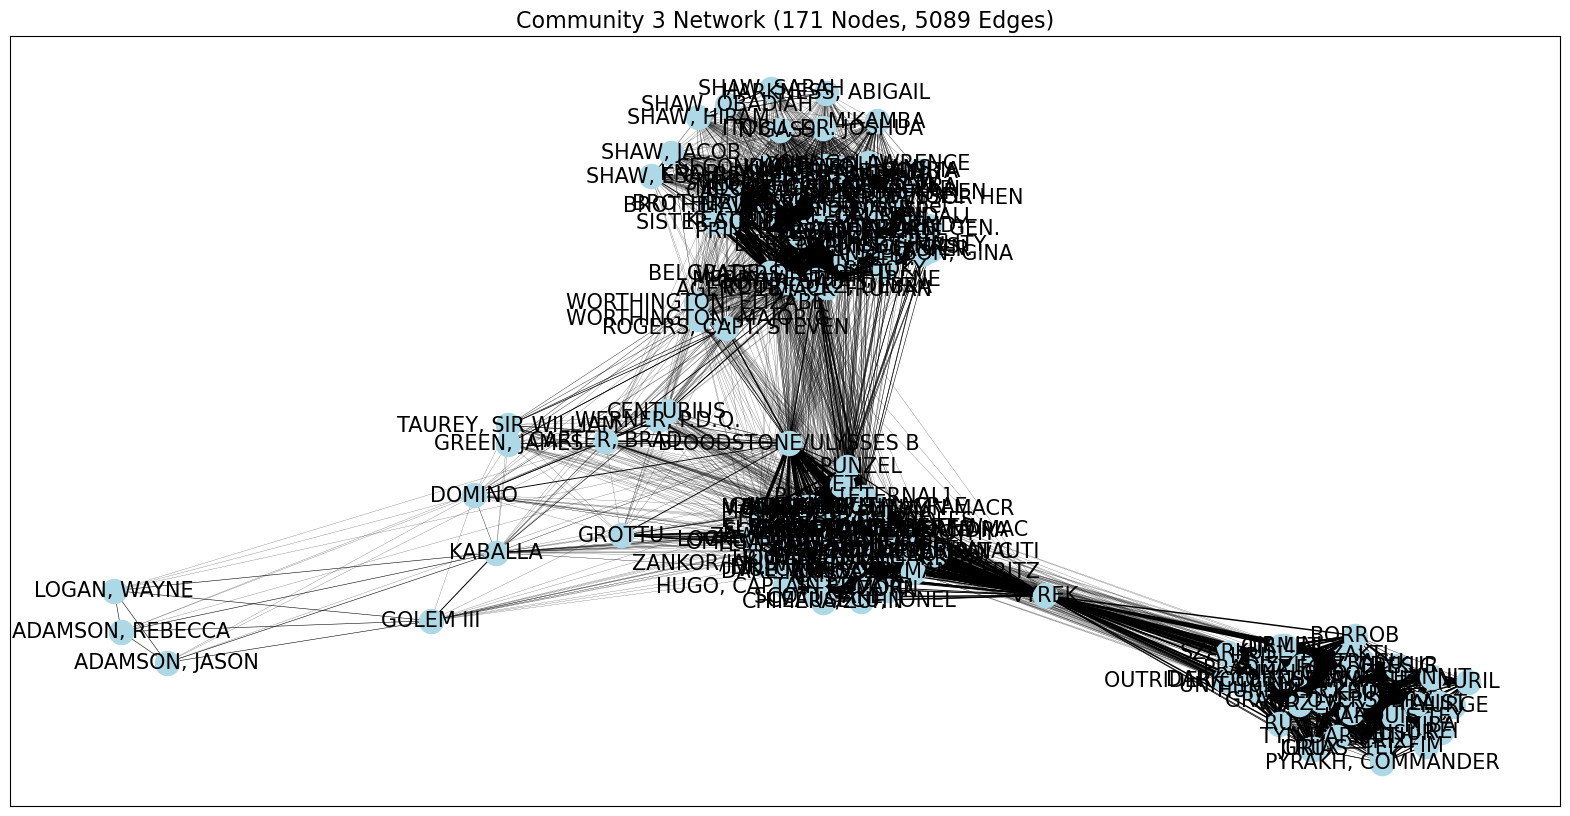

Top 10 Kantengewichte der Helden in der Community 3:
BLACK FOX/ROBERT W. - PIXIE/ [ETERNAL]: 76
EFFIGY/LT. VELMAX/JA - BLACK FOX/ROBERT W.: 75
EFFIGY/LT. VELMAX/JA - PIXIE/ [ETERNAL]: 74
MR. JUSTICE/TIMOTHY - EFFIGY/LT. VELMAX/JA: 72
MR. JUSTICE/TIMOTHY - BLACK FOX/ROBERT W.: 72
MR. JUSTICE/TIMOTHY - PIXIE/ [ETERNAL]: 72
LOCKE, DR. CASSANDRA - PIXIE/ [ETERNAL]: 63
OXBOW/ - EFFIGY/LT. VELMAX/JA: 63
OXBOW/ - PIXIE/ [ETERNAL]: 63
YETI - PIXIE/ [ETERNAL]: 62


In [37]:
plot_community(G_one_mode, communities, 2)

Interessanterweise sehen wir in diesem Community weitere Gruppierungen von Helden.

##### Edge Betweenness

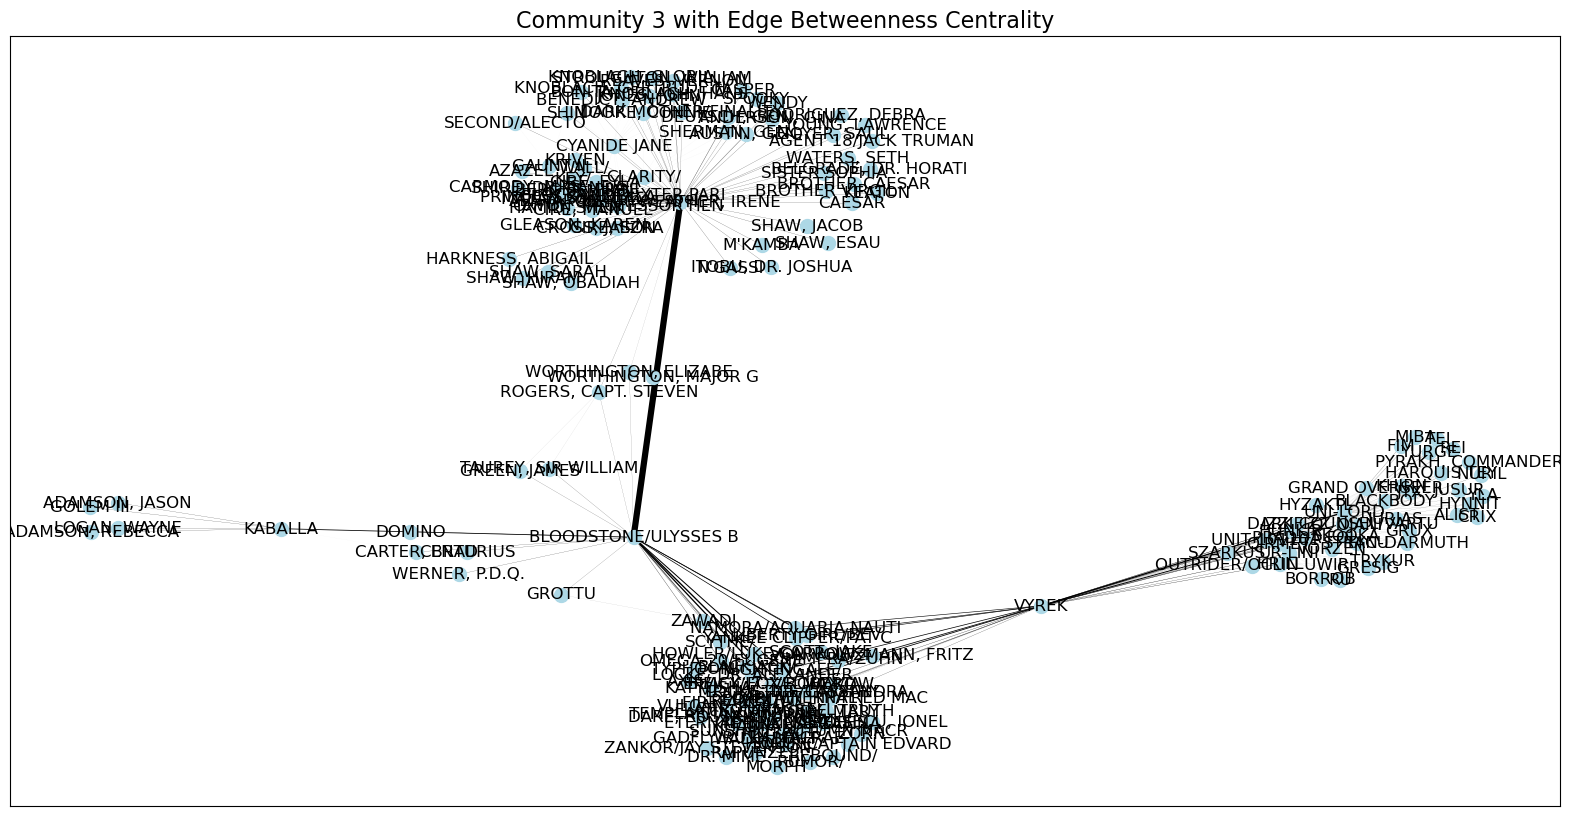

Top 10 Edges by Edge Betweenness Centrality in Community 3:
('MERRYWEATHER, IRENE', 'BLOODSTONE/ULYSSES B'): 0.4479
('UNI-LORD', 'VYREK'): 0.0982
('BLACK FOX/ROBERT W.', 'BLOODSTONE/ULYSSES B'): 0.0971
('EFFIGY/LT. VELMAX/JA', 'BLOODSTONE/ULYSSES B'): 0.0944
('NIGHTINGALE/', 'BLOODSTONE/ULYSSES B'): 0.0731
('DARK COUNSEL/VARTU', 'VYREK'): 0.0712
('BLACK FOX/ROBERT W.', 'VYREK'): 0.0569
('KABALLA', 'BLOODSTONE/ULYSSES B'): 0.0561
('EFFIGY/LT. VELMAX/JA', 'VYREK'): 0.0555
('NIGHTINGALE/', 'VYREK'): 0.0507


In [38]:
plot_community_edge_betweenness(G_one_mode, communities, 2)

Wie beim oberen Plot sehen wir kleinere Gruppierungen im Community. Mittels Edge Betweenness können wir jedoch die Verbindungen zwischen den einzelnen Gruppierungen viel besser sehen. Die dicksten Kanten sind diejenigen, die die einzelnen Gruppierungen zusammenhalten.

die Kante 'MERRYWEATHER, IRENE', 'BLOODSTONE/ULYSSES B' hat bei weitem die höchste Edge Betweenness und wir sehen ihre Wichtigkeit in der Visualisierung, wie sie das Netzwerk zusammenhält.

#### Community 7

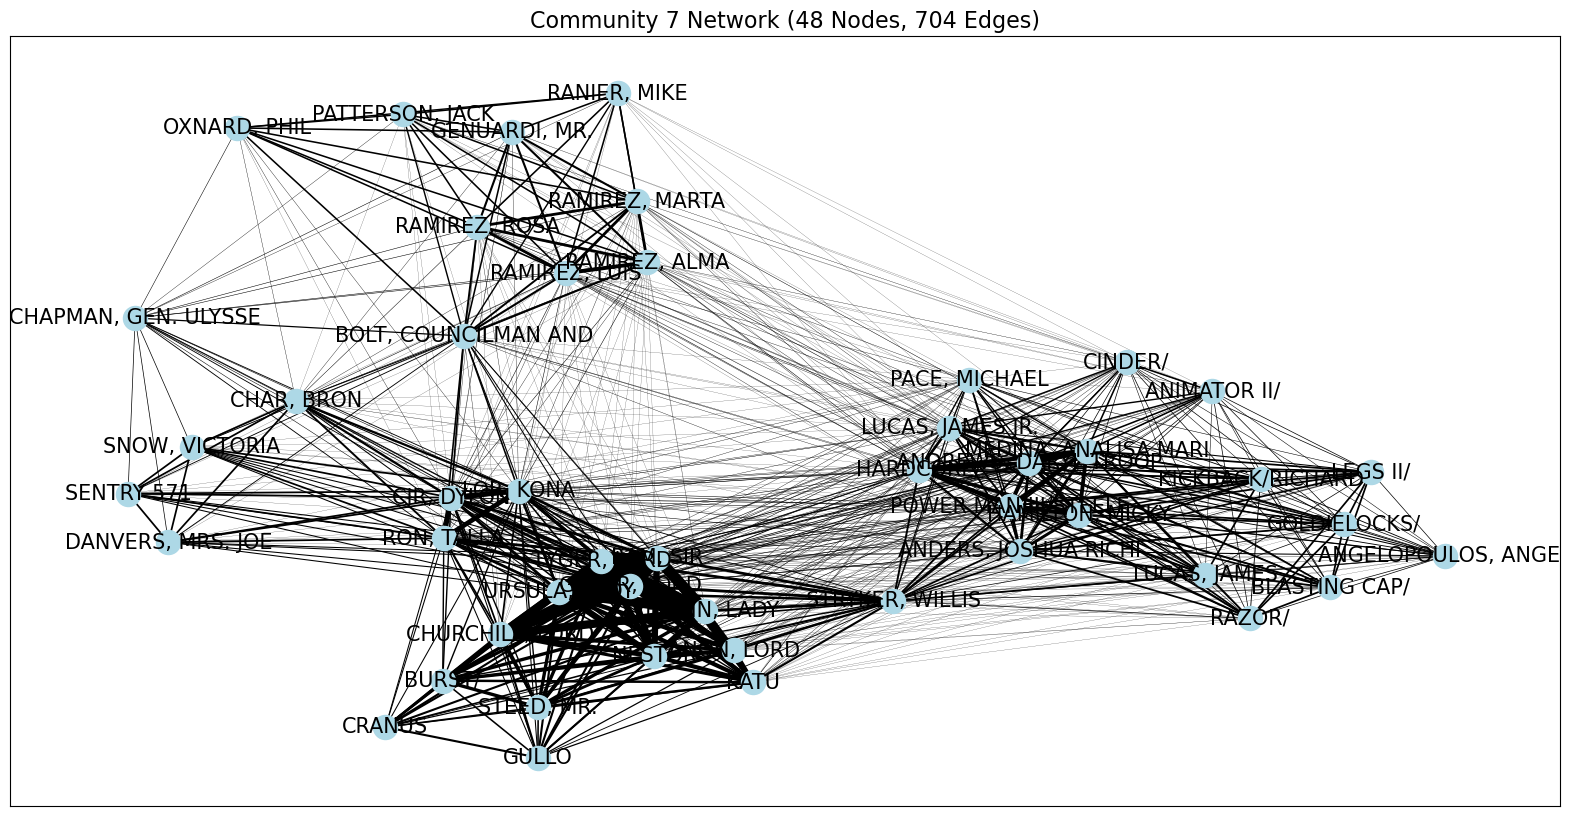

Top 10 Kantengewichte der Helden in der Community 7:
RAM, SIR - GATOR, LORD: 79
RAM, SIR - URSULA, LADY: 75
GATOR, LORD - URSULA, LADY: 75
RAM, SIR - TYGER, LORD: 71
TYGER, LORD - GATOR, LORD: 71
TYGER, LORD - URSULA, LADY: 67
RAM, SIR - VERMIN, LADY: 63
TYGER, LORD - VERMIN, LADY: 63
GATOR, LORD - VERMIN, LADY: 63
URSULA, LADY - VERMIN, LADY: 59


In [39]:
plot_community(G_one_mode, communities, 6)

##### Edge Betweenness

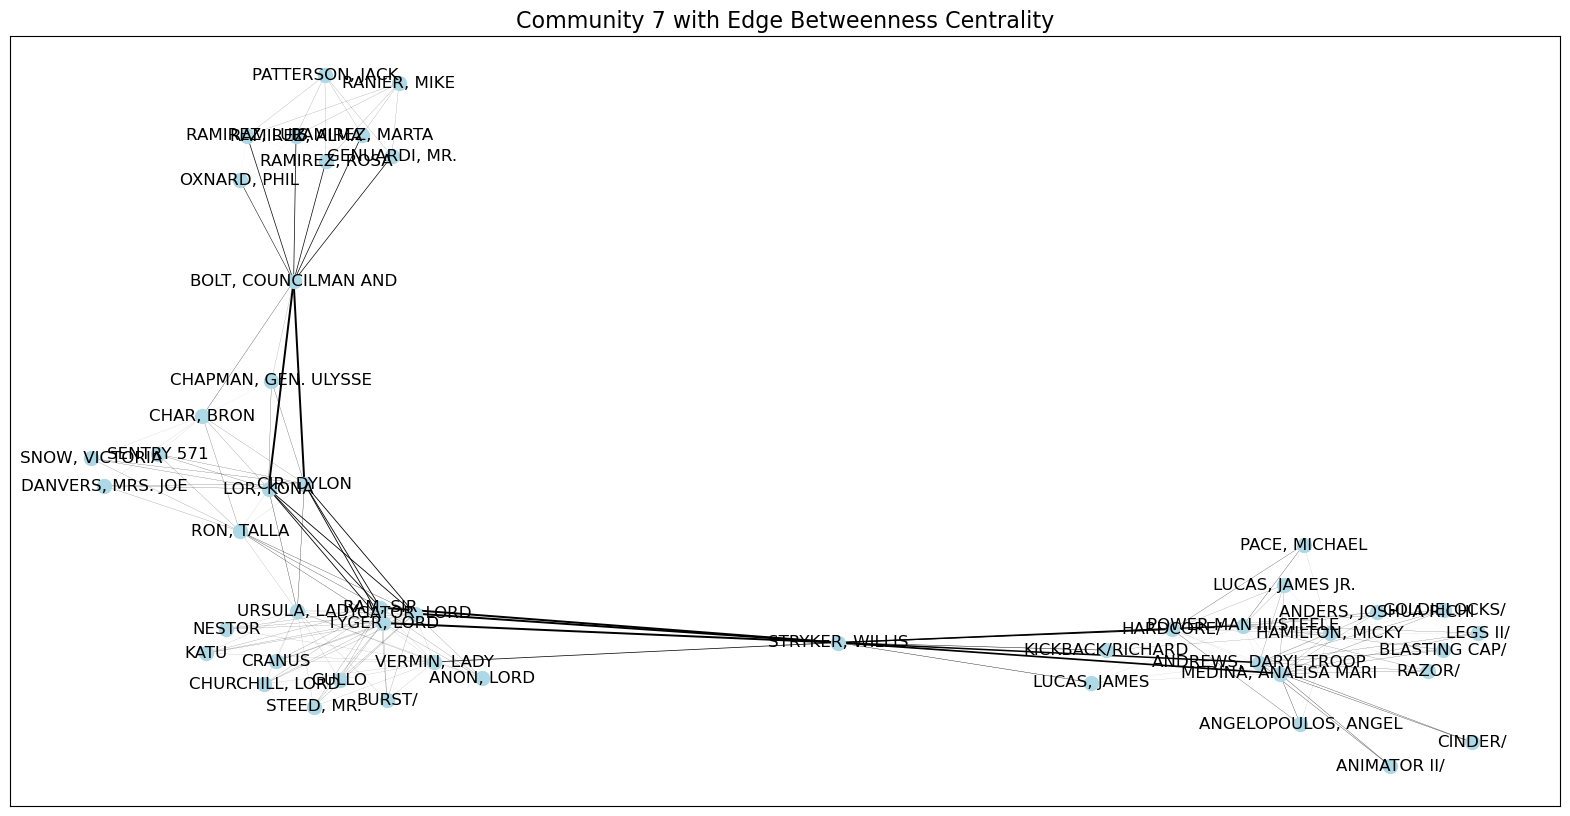

Top 10 Edges by Edge Betweenness Centrality in Community 7:
('BOLT, COUNCILMAN AND', 'LOR, KONA'): 0.1423
('BOLT, COUNCILMAN AND', 'CIR, DYLON'): 0.1423
('RAM, SIR', 'STRYKER, WILLIS'): 0.1423
('TYGER, LORD', 'STRYKER, WILLIS'): 0.1423
('GATOR, LORD', 'STRYKER, WILLIS'): 0.1423
('MEDINA, ANALISA MARI', 'STRYKER, WILLIS'): 0.1246
('ANDREWS, DARYL TROOP', 'STRYKER, WILLIS'): 0.1108
('POWER MAN III/STEELE', 'STRYKER, WILLIS'): 0.0971
('HARDCORE/', 'STRYKER, WILLIS'): 0.0742
('RAM, SIR', 'CIR, DYLON'): 0.0601


In [40]:
plot_community_edge_betweenness(G_one_mode, communities, 6)

Einige Charaktere, insbesondere die in der Mitte des Netzwerks, spielen Schlüsselrollen innerhalb ihrer Gemeinschaft, da sie mehrere dickere Kanten haben (höhere Edge-Betweenness) und so die "Sub-Netzwerke" verbinden. Zum Beispiel: 
- 'STRYKER, WILLIS'
- 'BOLT, COUNCILMAN AND'
- 'TYGER, LORD'
- 'GATOR, LORD'

#### Community 14

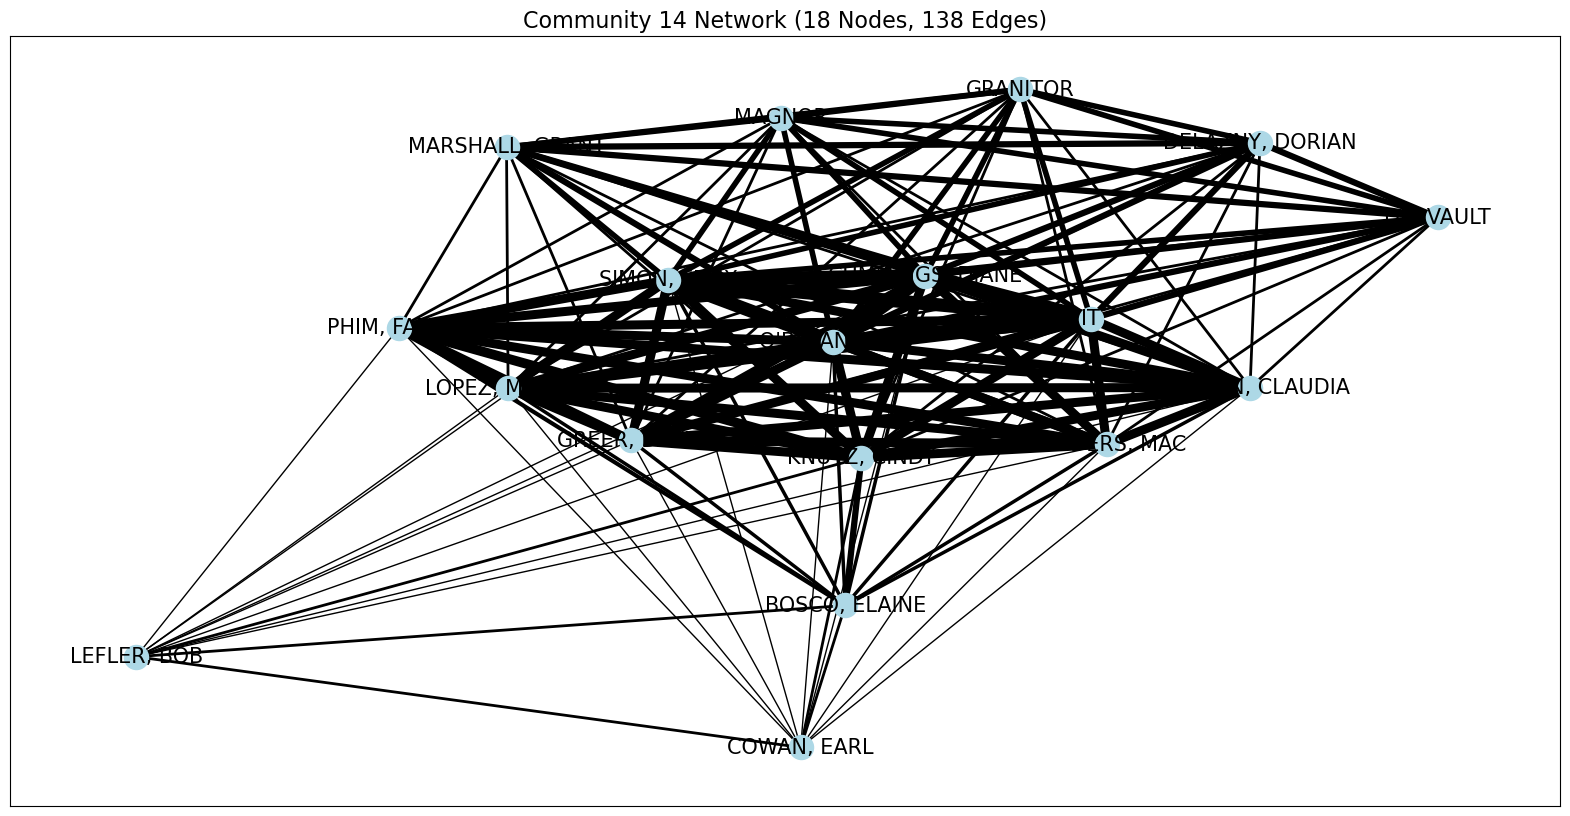

Top 10 Kantengewichte der Helden in der Community 14:
O'BRYAN, BOB - IT: 20
O'BRYAN, BOB - CUMMINGS, DIANE: 20
IT - CUMMINGS, DIANE: 20
O'BRYAN, BOB - SIMON, FELIX: 19
IT - SIMON, FELIX: 19
SIMON, FELIX - CUMMINGS, DIANE: 19
PHIM, FATHER - KNUTZ, CINDY: 14
LOPEZ, MARIA II - GREER, DAVID: 13
LOPEZ, MARIA II - MUNSON, CLAUDIA: 13
LOPEZ, MARIA II - O'BRYAN, BOB: 13


In [41]:
plot_community(G_one_mode, communities, 13)

In diesem Netzwerk ist es interessant zu sehen, dass sehr viele Helden eine starke Verbindung miteinander haben. Nur wenige haben eine kleinere Kantengewichtung. Dies deutet darauf hin, dass die Helden in dieser Gemeinschaft in vielen verschiedenen Comics zusammen auftreten. Es gibt keine "Brücken"-Helden, die die Gemeinschaft mit anderen Helden verbinden. Dies ist ein Hinweis darauf, dass die Helden in dieser Gemeinschaft in vielen verschiedenen Comics zusammen auftreten.

##### Edge Betweenness

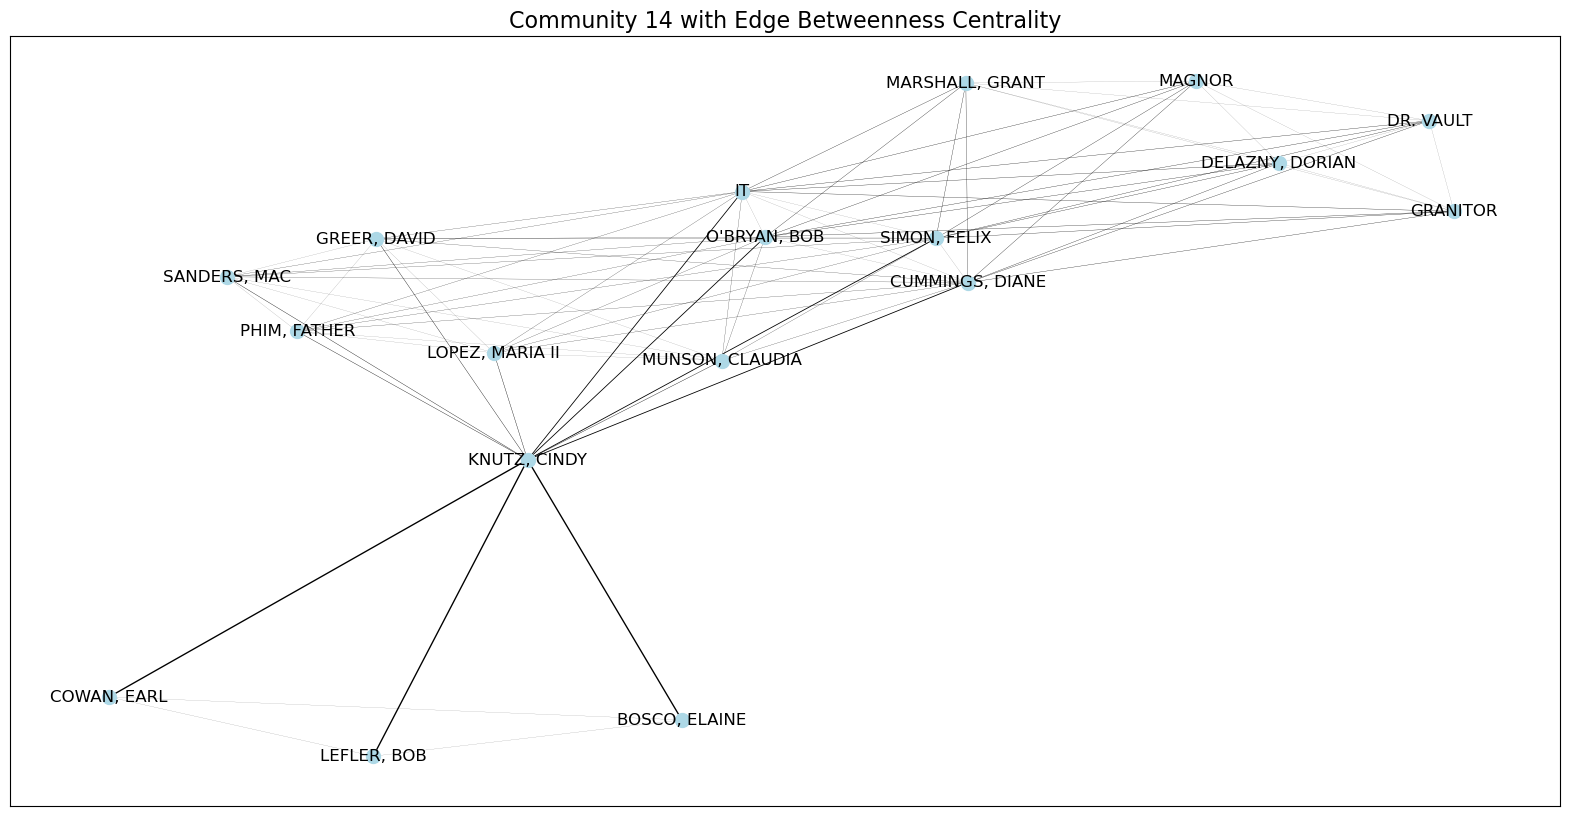

Top 10 Edges by Edge Betweenness Centrality in Community 14:
('COWAN, EARL', 'KNUTZ, CINDY'): 0.0980
('BOSCO, ELAINE', 'KNUTZ, CINDY'): 0.0980
('LEFLER, BOB', 'KNUTZ, CINDY'): 0.0980
("O'BRYAN, BOB", 'KNUTZ, CINDY'): 0.0588
('IT', 'KNUTZ, CINDY'): 0.0588
('KNUTZ, CINDY', 'CUMMINGS, DIANE'): 0.0588
('KNUTZ, CINDY', 'SIMON, FELIX'): 0.0588
('LOPEZ, MARIA II', 'KNUTZ, CINDY'): 0.0261
('GREER, DAVID', 'KNUTZ, CINDY'): 0.0261
('MUNSON, CLAUDIA', 'KNUTZ, CINDY'): 0.0261


In [42]:
plot_community_edge_betweenness(G_one_mode, communities, 13)

Bei diesem Netzwerk sind die Verbindungen ausgeglichener und es gibt nicht wirklich eine Kante, welche evrschiedene Gruppierungen des Geeinschafts zusammenhält. Ausser die Verbindungen zu 'KNUTZ, CINDY' sind etwas stärker.

### Top 100 Helden Netzwerk

Wir werden nun untersuchen, welche Gemeinschaften es bei den 100 am häufigsten vorkommenden Helden gibt.

#### Gemeinschaften

Gemeinschaft 1: ['ANGEL/WARREN KENNETH', 'ANT-MAN/DR. HENRY J.', 'BALDER [ASGARDIAN]', 'BANNER, BETTY ROSS T', "BLACK PANTHER/T'CHAL", 'CAGE, LUKE/CARL LUCA', 'CAPTAIN MARVEL II/MO', 'CLEA', 'CRYSTAL [INHUMAN]', 'CYCLOPS/SCOTT SUMMER'] ... [55 Helden]
Gemeinschaft 2: ['BANSHEE/SEAN CASSIDY', 'BEAST/HENRY &HANK& P', 'BINARY/CAROL DANVERS', 'BLACK KNIGHT V/DANE', 'BLACK WIDOW/NATASHA', 'BOOMER/TABITHA SMITH', 'CANNONBALL II/SAM GU', 'CAPTAIN AMERICA', 'CAPTAIN BRITAIN/BRIA', 'COLOSSUS II/PETER RA'] ... [45 Helden]

Total number of communities detected: 2


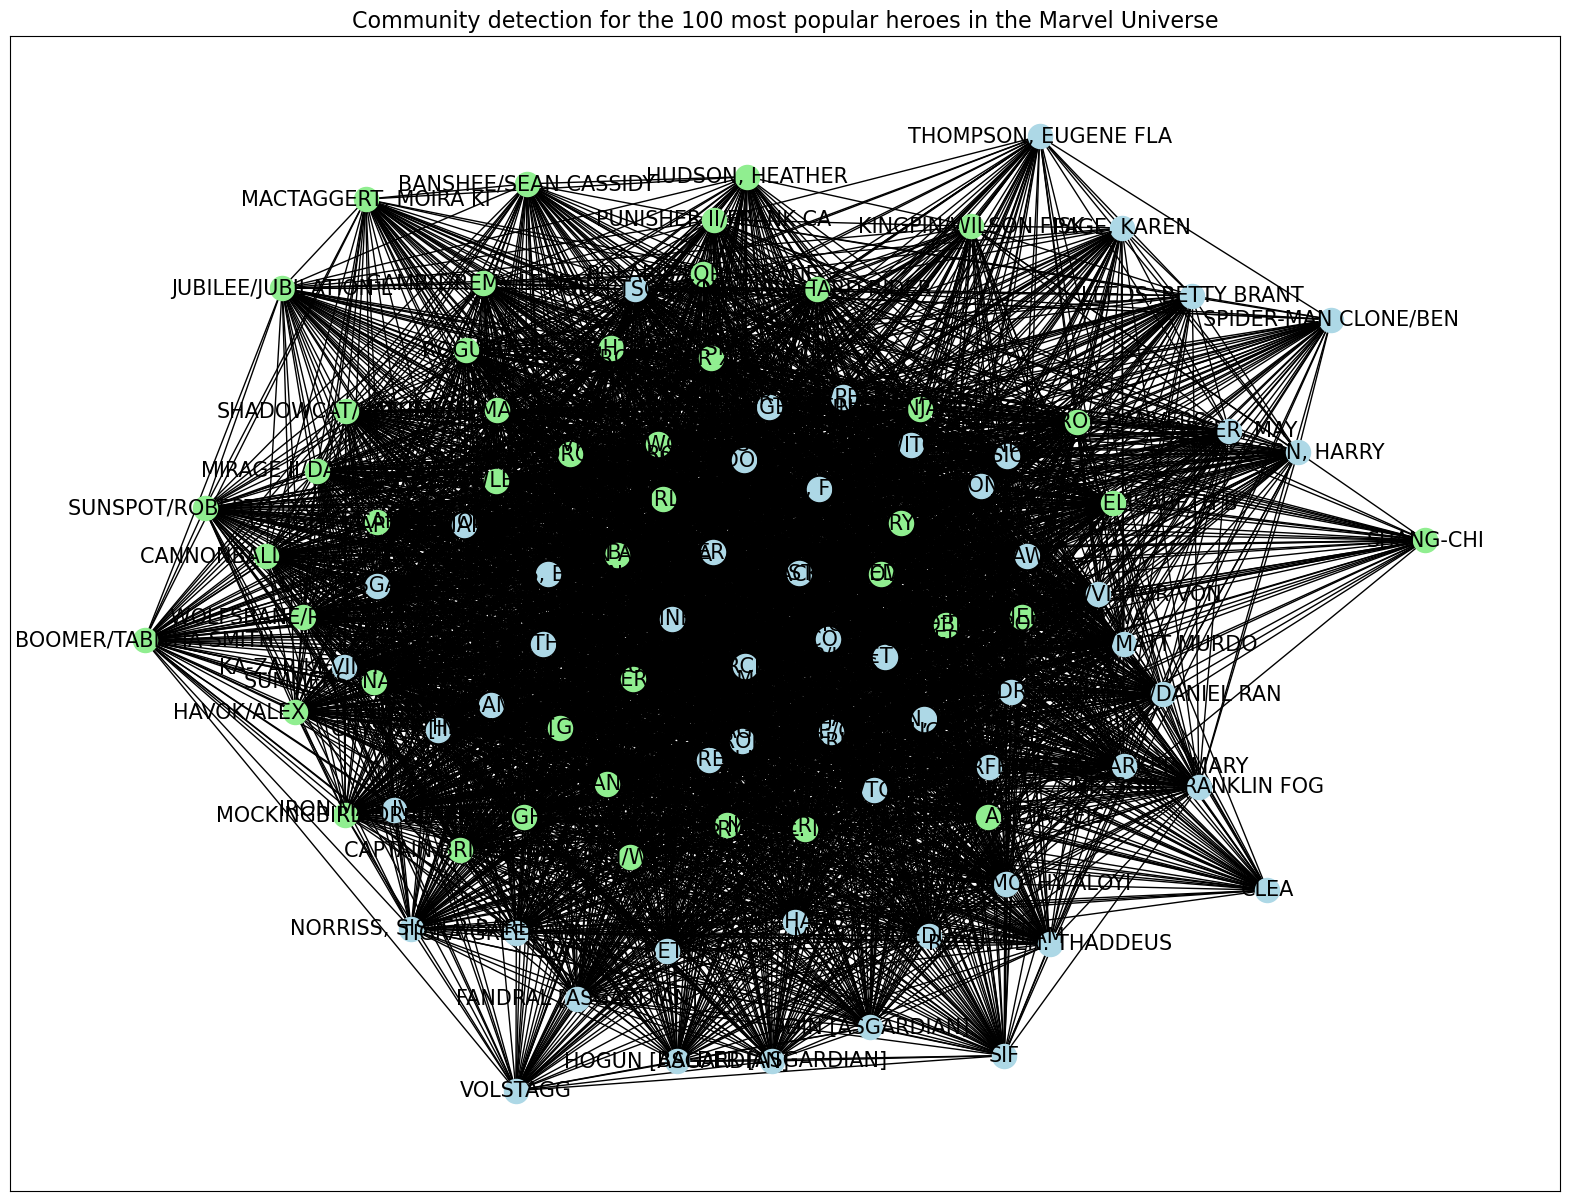

In [43]:
communities_top_100 = get_communities(top_heroes_subgraph)

plt.figure(figsize=(20, 15))
plt.title("Community detection for the 100 most popular heroes in the Marvel Universe", fontsize=16)
draw_graph_and_color_groups(top_heroes_subgraph, communities_top_100, "spring")
plt.show()

Die Greedy Modularity Methode liefert bei dem Netzwerk mit den top 100 Helden 2 verschiedene Communities. Die Visualisierung zeigt eine hohe Dichte an Verbindungen zwischen den Helden, was die Zusammenarbeit und Interaktionen innerhalb des Marvel-Universums widerspiegelt. Einige Helden scheinen zentrale Knotenpunkte in ihren Gemeinschaften zu sein, mit vielen Verbindungen zu anderen Helden derselben Community.

#### Community 1

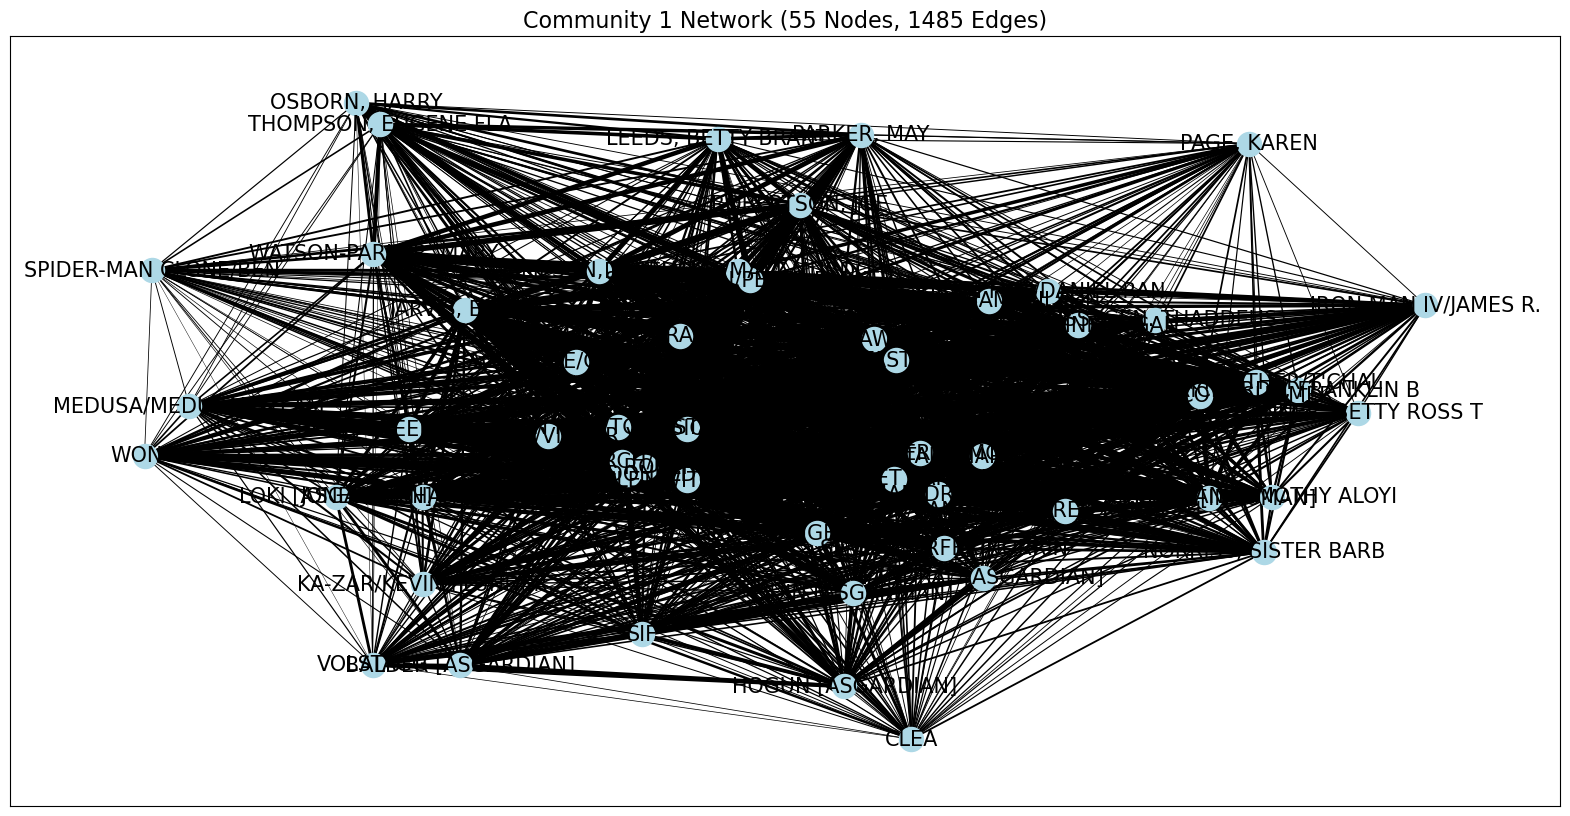

Top 10 Kantengewichte der Helden in der Community 1:
HUMAN TORCH/JOHNNY S - MR. FANTASTIC/REED R: 1177
IRON MAN/TONY STARK - SCARLET WITCH/WANDA: 1079
SCARLET WITCH/WANDA - VISION: 1038
IRON MAN/TONY STARK - VISION: 958
IRON MAN/TONY STARK - THOR/DR. DONALD BLAK: 919
IRON MAN/TONY STARK - HAWK: 916
ANGEL/WARREN KENNETH - CYCLOPS/SCOTT SUMMER: 914
CYCLOPS/SCOTT SUMMER - WOLVERINE/LOGAN: 901
WASP/JANET VAN DYNE - IRON MAN/TONY STARK: 894
SCARLET WITCH/WANDA - HAWK: 885


In [44]:
plot_community(G_one_mode, communities_top_100, 0)

#### Community 2

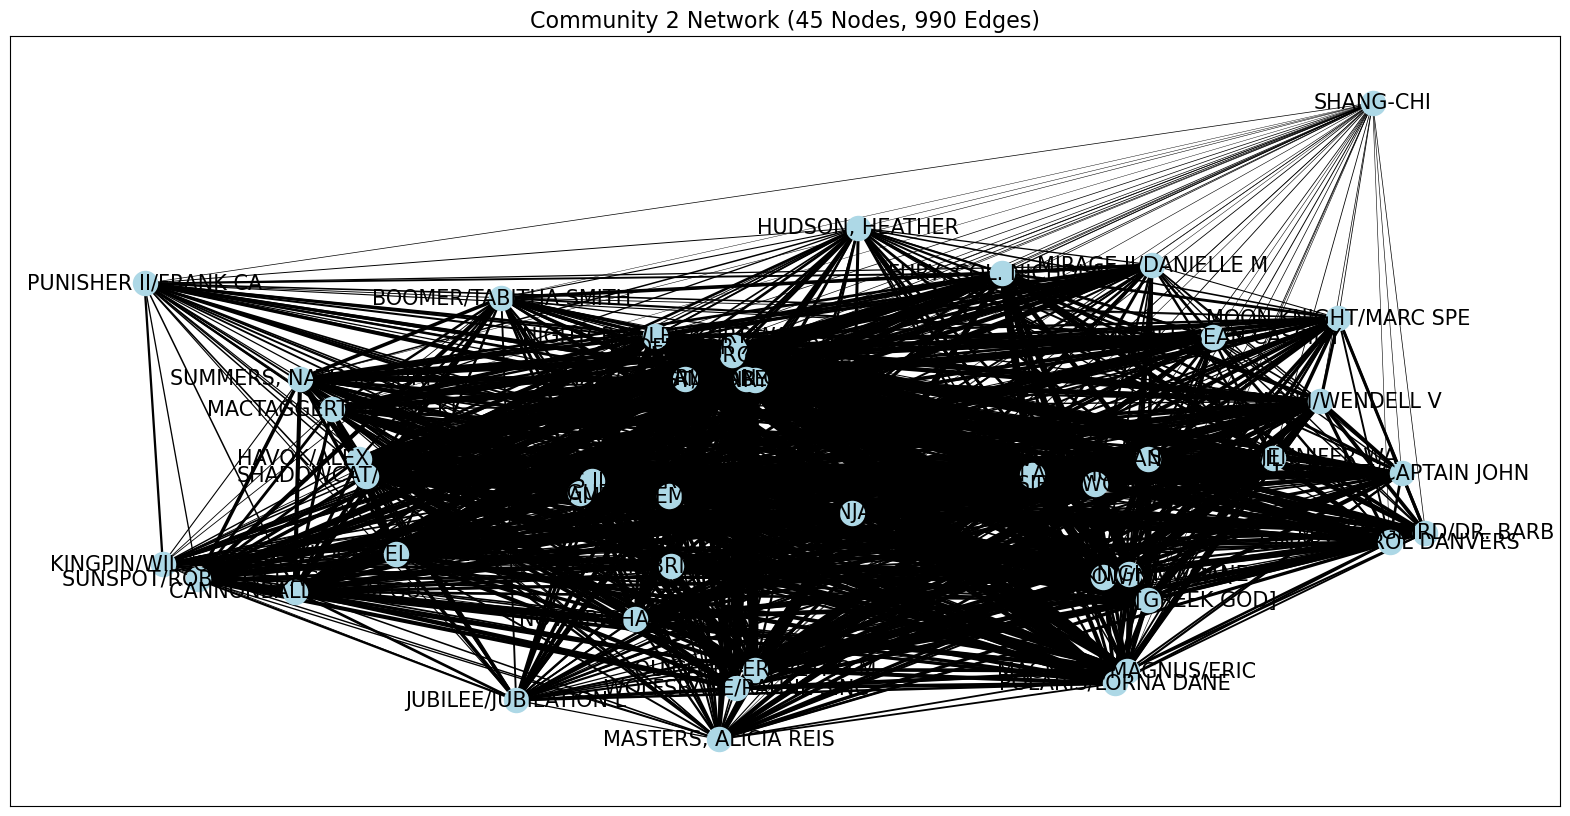

Top 10 Kantengewichte der Helden in der Community 2:
INVISIBLE WOMAN/SUE - THING/BENJAMIN J. GR: 1176
THING/BENJAMIN J. GR - CAPTAIN AMERICA: 969
COLOSSUS II/PETER RA - STORM/ORORO MUNROE S: 910
SHE-HULK/JENNIFER WA - CAPTAIN AMERICA: 883
INVISIBLE WOMAN/SUE - CAPTAIN AMERICA: 882
ICEMAN/ROBERT BOBBY - BEAST/HENRY &HANK& P: 879
WONDER MAN/SIMON WIL - CAPTAIN AMERICA: 873
MARVEL GIRL/JEAN GRE - BEAST/HENRY &HANK& P: 868
BEAST/HENRY &HANK& P - CAPTAIN AMERICA: 858
HERCULES [GREEK GOD] - CAPTAIN AMERICA: 838


In [45]:
plot_community(G_one_mode, communities_top_100, 1)

Beim ganzen Netzwerk haben wir bei einigen Communities die Edge-Betweenness-Zentralität berechnet. Hier ist dies nicht nötig, da die Communities so stark vernetzt sind. Die Edge-Betweenness-Zentralität wären bei allen Kanten ungefähr gleich und ist daher für die Analyse nicht förderlich.

### Was haben wir von der Community-Detection gelernt?

- Existenz von Gemeinschaften: Wir haben festgestellt, dass es klar definierte Gruppen oder Gemeinschaften von Helden gibt, die häufig zusammen in Comics erscheinen. Diese Gemeinschaften können Teams, Allianzen oder andere Gruppierungen von Charakteren repräsentieren, die in der Erzählwelt gemeinsame Ziele oder Feinde haben.

- Schlüsselcharaktere: Innerhalb der identifizierten Gemeinschaften haben wir durch die Berechnung der Edge Betweenness Centrality wichtige Charaktere identifiziert, die als zentrale Verbindungspunkte dienen. Diese Charaktere spielen oft eine entscheidende Rolle in der Erzählung, da sie verschiedene Handlungsstränge zusammenführen oder als wichtige Mitglieder ihrer Gruppen fungieren.

- Netzwerkdichte: Die Visualisierung des Netzwerks hat gezeigt, dass einige Gemeinschaften eine sehr dichte Vernetzung aufweisen, was auf enge Beziehungen und regelmässige Interaktionen zwischen den Mitgliedern hinweist.

- Randfiguren: Ebenso konnten wir beobachten, dass es Charaktere gibt, die weniger zentral sind und am Rand der Gemeinschaften stehen. Diese könnten Nebencharaktere sein, die weniger Einfluss auf die Haupterzählung haben.

## Frage 4 - Identifizierung von Helden mit einem Grad von 1

Diese Frage geht auf unsere Erkenntnisse in der Explorativen Datenanalyse zurück. Wir haben festgestellt, dass es Helden gibt, die nur in einem einzigen Comic auftreten.

In [46]:
# Calculate degree
degrees = {hero: B.degree(hero) for hero in B.nodes()}

# Filter out the heroes with only one comic
heroes_with_one_comic = [hero for hero, deg in degrees.items() if deg == 1]

print("Anzahl Helden im gesamten Datensatz, welche nur in einem einzigen Comic erscheinen:", len(heroes_with_one_comic))
print(heroes_with_one_comic[:5])

Anzahl Helden im gesamten Datensatz, welche nur in einem einzigen Comic erscheinen: 3275
['24-HOUR MAN/EMMANUEL', 'ABBOTT, JACK', 'ABOMINATION | MUTANT', 'ABSORBING MAN | MUTA', 'ACBA']


In [47]:
# Filtern nach Helden mit dem höchsten Grad
top_degree_hero, degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[0]
print(top_degree_hero + " hat den höchsten Grad mit " + str(degree) + " Comics.")

SPIDER-MAN/PETER PARKER hat den höchsten Grad mit 1577 Comics.


# comics als nodes und zentralitäten berechnen

# comics communities

# in welchem comics die meisten superhelden sind (top 100 comics)

# comic übereinstimmungen -> fortsetzungen?

# Welche helden kommen in allen COC comics vor?

## Frage ... Welche Helden könnten in einem Comic zusammen auftreten?

Verwendung von Link Predictions

In [49]:
import itertools
import networkx as nx

def predict_links(G, top_n=10):
    """
    Predict future links using the number of common neighbors.
    
    Parameters:
    G (nx.Graph): The graph on which to perform link prediction.
    top_n (int): The number of link predictions to return.
    
    Returns:
    list of tuples: A list of the top predicted links and their scores.
    """
    # Berechne alle möglichen nicht vorhandenen Kanten
    potential_links = [(node1, node2) for node1, node2 in itertools.combinations(G.nodes(), 2) if not G.has_edge(node1, node2)]
    
    # Bewerte die potenziellen Kanten basierend auf der Anzahl gemeinsamer Nachbarn
    scores = [(node1, node2, len(list(nx.common_neighbors(G, node1, node2)))) for node1, node2 in potential_links]
    
    # Sortiere die potenziellen Kanten basierend auf ihren Scores
    scores.sort(key=lambda x: x[2], reverse=True)
    
    # Gebe die Top-N Kanten und Scores zurück
    return scores[:top_n]

# Anwendung der Funktion auf das G_one_mode Netzwerk
predicted_links = predict_links(G_one_mode, top_n=10)
for link in predicted_links:
    print(f"{link[0]} - {link[1]}: {link[2]} gemeinsame Comics")


CAPTAIN MARVEL II/MO - ICEMAN/ROBERT BOBBY: 288 gemeinsame Comics
HAVOK/ALEX SUMMERS - JARVIS, EDWIN: 265 gemeinsame Comics
JAMESON, J. JONAH - SHADOWCAT/KATHERINE: 250 gemeinsame Comics
BLOB/FRED J. DUKES - THING/BENJAMIN J. GR: 243 gemeinsame Comics
BLOB/FRED J. DUKES - HUMAN TORCH/JOHNNY S: 237 gemeinsame Comics
BANSHEE/SEAN CASSIDY - IRON MAN/TONY STARK: 236 gemeinsame Comics
BLOB/FRED J. DUKES - INVISIBLE WOMAN/SUE: 236 gemeinsame Comics
CAPTAIN BRITAIN/BRIA - JARVIS, EDWIN: 233 gemeinsame Comics
RICHARDS, FRANKLIN B - SERSI/SYLVIA: 233 gemeinsame Comics
MARVEL GIRL/JEAN GRE - TIGRA/GREER NELSON: 232 gemeinsame Comics


Aufgelistet sind Paare von Marvel-Helden, die basierend auf der Anzahl ihrer gemeinsamen Auftritte in Comics wahrscheinlich starke Verbindungen haben. Die Zahlen geben an, wie oft die jeweiligen Paare zusammen in Comics erschienen sind.